# Swing Option Valuation Analysis

Quantitative analysis of swing option pricing data to calculate value per rights and exercise efficiency metrics.

## Import Libraries and Load Data

In [11]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# Load parameters and evaluation data
csv_path = "../logs/Yearly_Swing/evaluation_runs/eval_run_8192.csv"
params_path = "../logs/Yearly_Swing/Yearly_Swing_parameters.json"

with open(params_path, 'r') as f:
    params = json.load(f)

data = pd.read_csv(csv_path)

print(f"Loaded {len(data)} observations across {params['n_paths_eval']} paths")
print(f"Total Rights: {params['n_rights']}, Strike: {params['strike']}, Maturity: {params['maturity']} years")

Loaded 204800 observations across 2048 paths
Total Rights: 100, Strike: 1.0, Maturity: 1.0 years


## Calculate Option Values and Exercise Statistics

In [12]:
# Group by episode to analyze each simulation path
episodes = data.groupby('episode_idx')

episode_values = []
exercise_efficiency = []
unused_rights = []
avg_exercise_prices = []

for episode_idx, episode_data in episodes:
    # Total value (sum of all rewards)
    total_value = episode_data['reward'].sum()
    
    # Exercise statistics
    final_row = episode_data.iloc[-1]
    total_exercised = final_row['q_exerc']
    efficiency = total_exercised / params['n_rights'] * 100
    unused = params['n_rights'] - total_exercised
    
    # Average exercise price
    exercise_data = episode_data[episode_data['q_actual'] > 0]
    if len(exercise_data) > 0:
        avg_price = (exercise_data['spot'] * exercise_data['q_actual']).sum() / exercise_data['q_actual'].sum()
    else:
        avg_price = 0
    
    episode_values.append(total_value)
    exercise_efficiency.append(efficiency)
    unused_rights.append(unused)
    avg_exercise_prices.append(avg_price)

episode_values = np.array(episode_values)
print(f"Processed {len(episode_values)} simulation paths")

Processed 2048 simulation paths


## Core Valuation Metrics

In [13]:
# Calculate comprehensive metrics
metrics = {
    'mean_value': np.mean(episode_values),
    'median_value': np.median(episode_values),
    'std_value': np.std(episode_values),
    'value_per_rights': np.mean(episode_values) / params['n_rights'],
    'var_95': np.percentile(episode_values, 5),
    'var_99': np.percentile(episode_values, 1),
    'mean_efficiency': np.mean(exercise_efficiency),
    'mean_unused': np.mean(unused_rights),
    'mean_exercise_price': np.mean(avg_exercise_prices),
    'skewness': stats.skew(episode_values),
    'kurtosis': stats.kurtosis(episode_values)
}

print("SWING OPTION VALUATION RESULTS")
print("=" * 50)
print(f"Mean Option Value:        {metrics['mean_value']:>12.2f}")
print(f"Value per Rights:         {metrics['value_per_rights']:>12.2f}")
print(f"Standard Deviation:       {metrics['std_value']:>12.2f}")
print(f"95% VaR:                  {metrics['var_95']:>12.2f}")
print(f"Exercise Efficiency:      {metrics['mean_efficiency']:>11.1f}%")
print(f"Mean Unused Rights:       {metrics['mean_unused']:>12.1f}")
print(f"Skewness:                 {metrics['skewness']:>12.3f}")

SWING OPTION VALUATION RESULTS
Mean Option Value:             6444.80
Value per Rights:                64.45
Standard Deviation:            1407.39
95% VaR:                       4475.76
Exercise Efficiency:             87.2%
Mean Unused Rights:               12.8
Skewness:                        0.779


## Visualization Dashboard

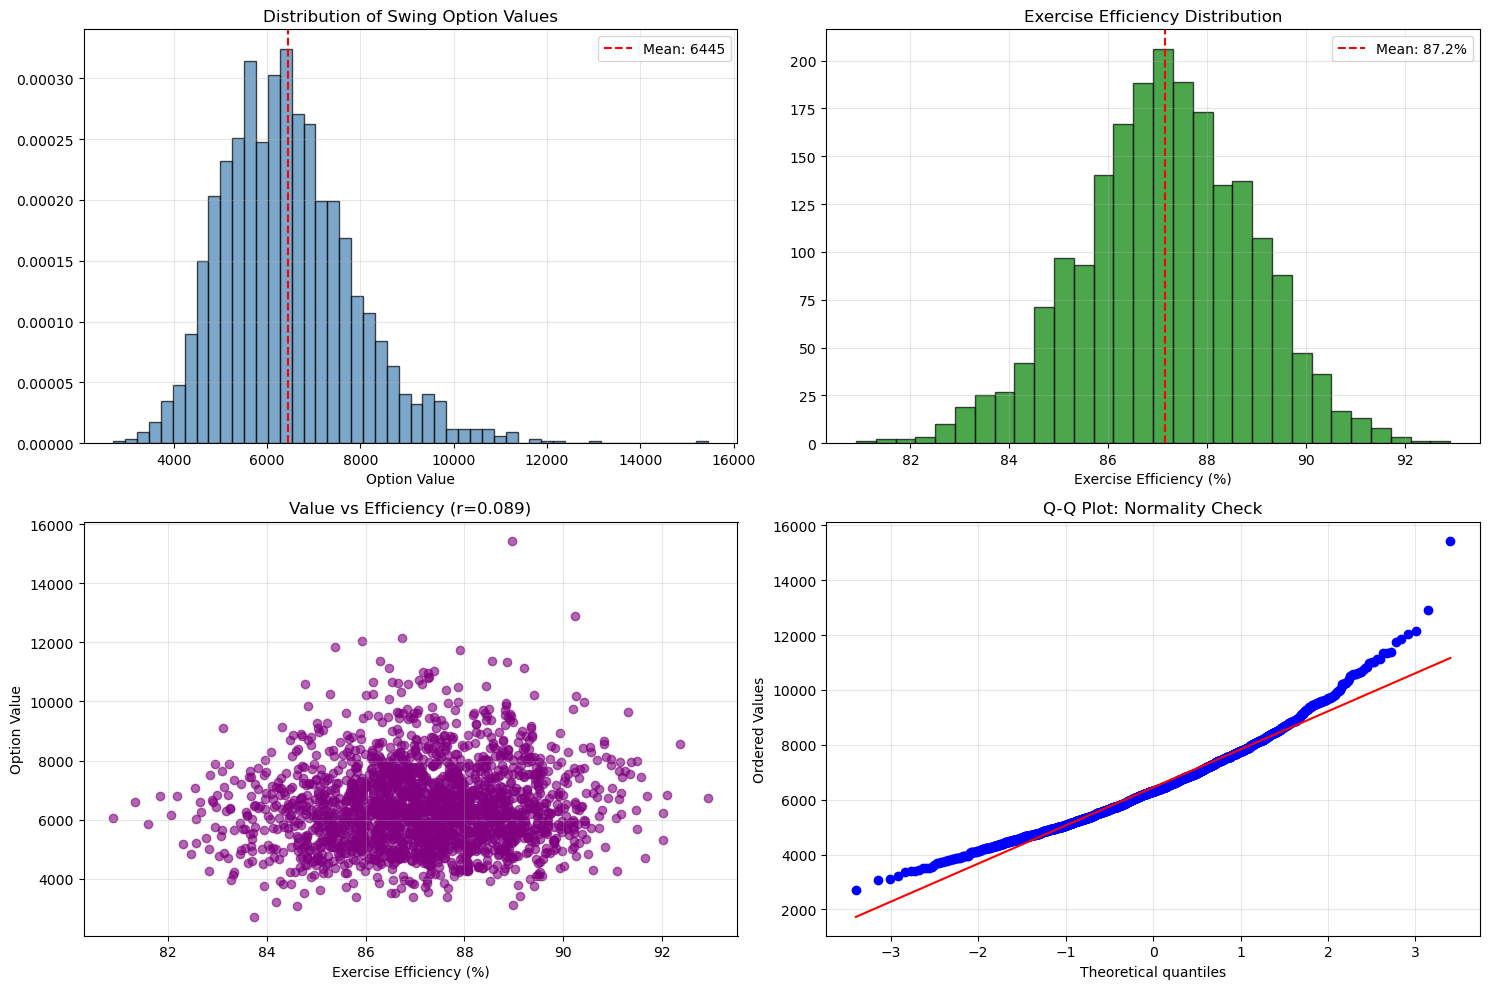

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Value distribution
ax1.hist(episode_values, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(metrics['mean_value'], color='red', linestyle='--', label=f'Mean: {metrics["mean_value"]:.0f}')
ax1.set_xlabel('Option Value')
ax1.set_title('Distribution of Swing Option Values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Exercise efficiency
ax2.hist(exercise_efficiency, bins=30, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(metrics['mean_efficiency'], color='red', linestyle='--', label=f'Mean: {metrics["mean_efficiency"]:.1f}%')
ax2.set_xlabel('Exercise Efficiency (%)')
ax2.set_title('Exercise Efficiency Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Value vs efficiency scatter
ax3.scatter(exercise_efficiency, episode_values, alpha=0.6, color='purple')
correlation = np.corrcoef(exercise_efficiency, episode_values)[0, 1]
ax3.set_xlabel('Exercise Efficiency (%)')
ax3.set_ylabel('Option Value')
ax3.set_title(f'Value vs Efficiency (r={correlation:.3f})')
ax3.grid(True, alpha=0.3)

# Q-Q plot for normality
stats.probplot(episode_values, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot: Normality Check')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Economic Interpretation

In [15]:
print("ECONOMIC INTERPRETATION:")
print(f"• Portfolio value: {metrics['mean_value']:.0f} with {metrics['value_per_rights']:.1f} per rights")
print(f"• Exercise efficiency: {metrics['mean_efficiency']:.1f}% ({metrics['mean_unused']:.1f} rights unused)")
print(f"• Risk profile: 95% VaR of {metrics['var_95']:.0f} with {'positive' if metrics['skewness'] > 0 else 'negative'} skew")
print(f"• Strategy appears {'well-optimized' if metrics['mean_efficiency'] > 80 else 'sub-optimal'} for value capture")

# Save results in the experiment logs directory
results_summary = {
    'valuation_metrics': metrics,
    'contract_parameters': params,
    'analysis_date': pd.Timestamp.now().isoformat()
}

output_path = '../logs/Yearly_Swing/swing_option_valuation_results.json'
with open(output_path, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print(f"\nResults saved to {output_path}")

ECONOMIC INTERPRETATION:
• Portfolio value: 6445 with 64.4 per rights
• Exercise efficiency: 87.2% (12.8 rights unused)
• Risk profile: 95% VaR of 4476 with positive skew
• Strategy appears well-optimized for value capture

Results saved to ../logs/Yearly_Swing/swing_option_valuation_results.json
